# [Arbitrage-free SVI volatility surfaces](https://arxiv.org/pdf/1204.0646.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,25),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 200

## Numerical experiments

In [4]:
f = 2*ONE_PCT

a=-0.0410
b=0.1331
m=0.1
rho=0.3060
sigma=0.415

moneyness_lo = 1/10
moneyness_hi = 2

In [5]:
Model_LN = SVI_Raw_LN(
    a=a,
    b=b,
    rho=rho,
    m=m,
    sigma=sigma,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)

## Shape of the smile

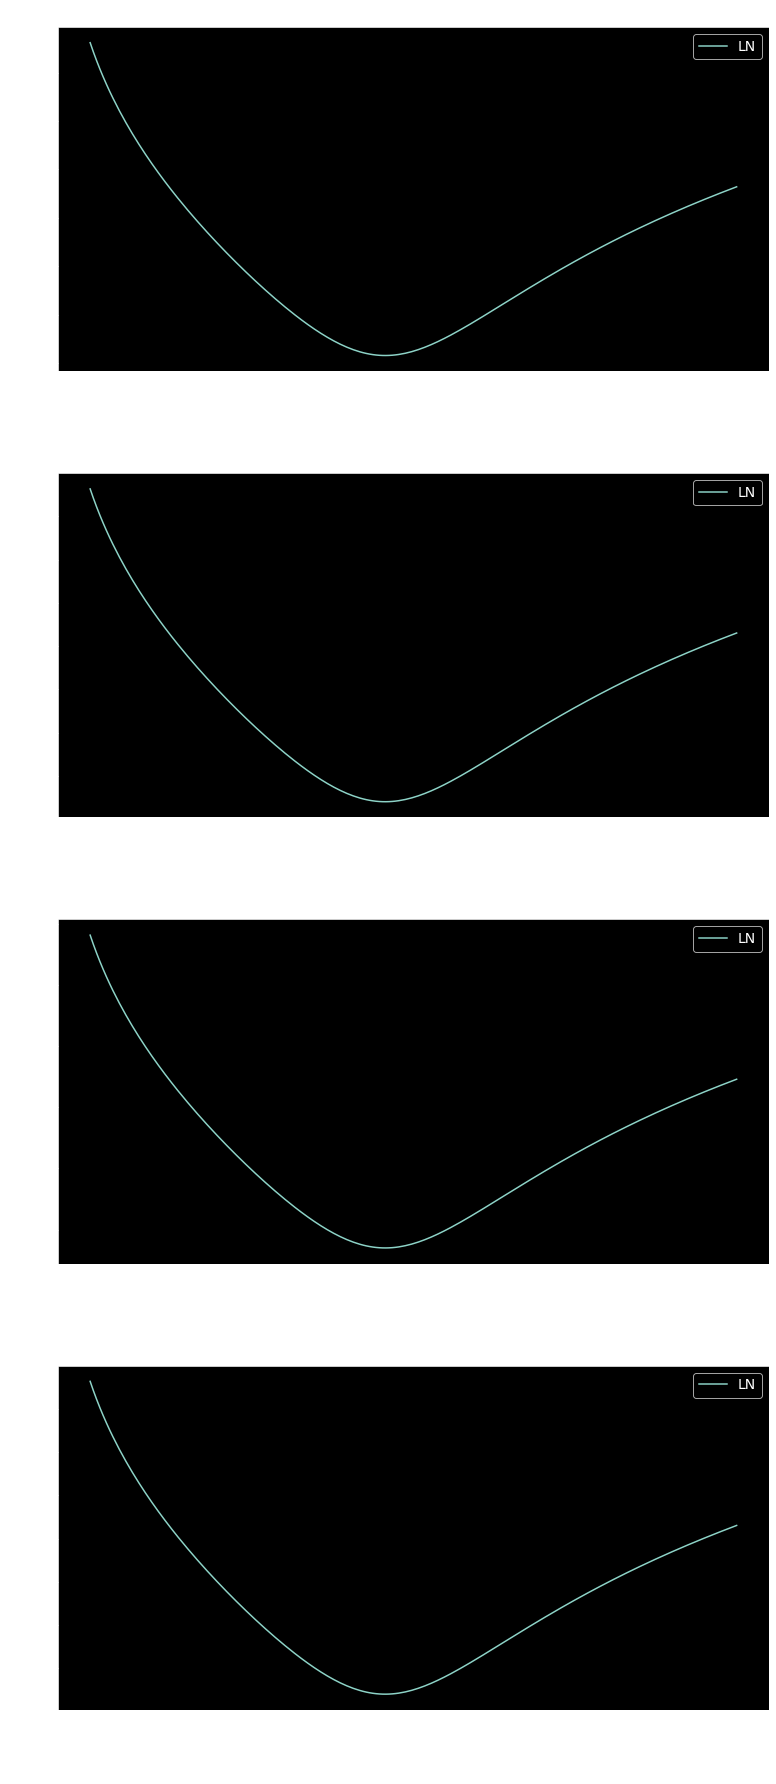

In [6]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    x_grid = Model_LN.strike_grid

    smile = list(Model_LN.smile.values())
    ax.plot(x_grid, smile, label='LN')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.set_title('expiry={}y'.format(T_expiry))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

plt.tight_layout()
plt.show()

## Implied underlyer density

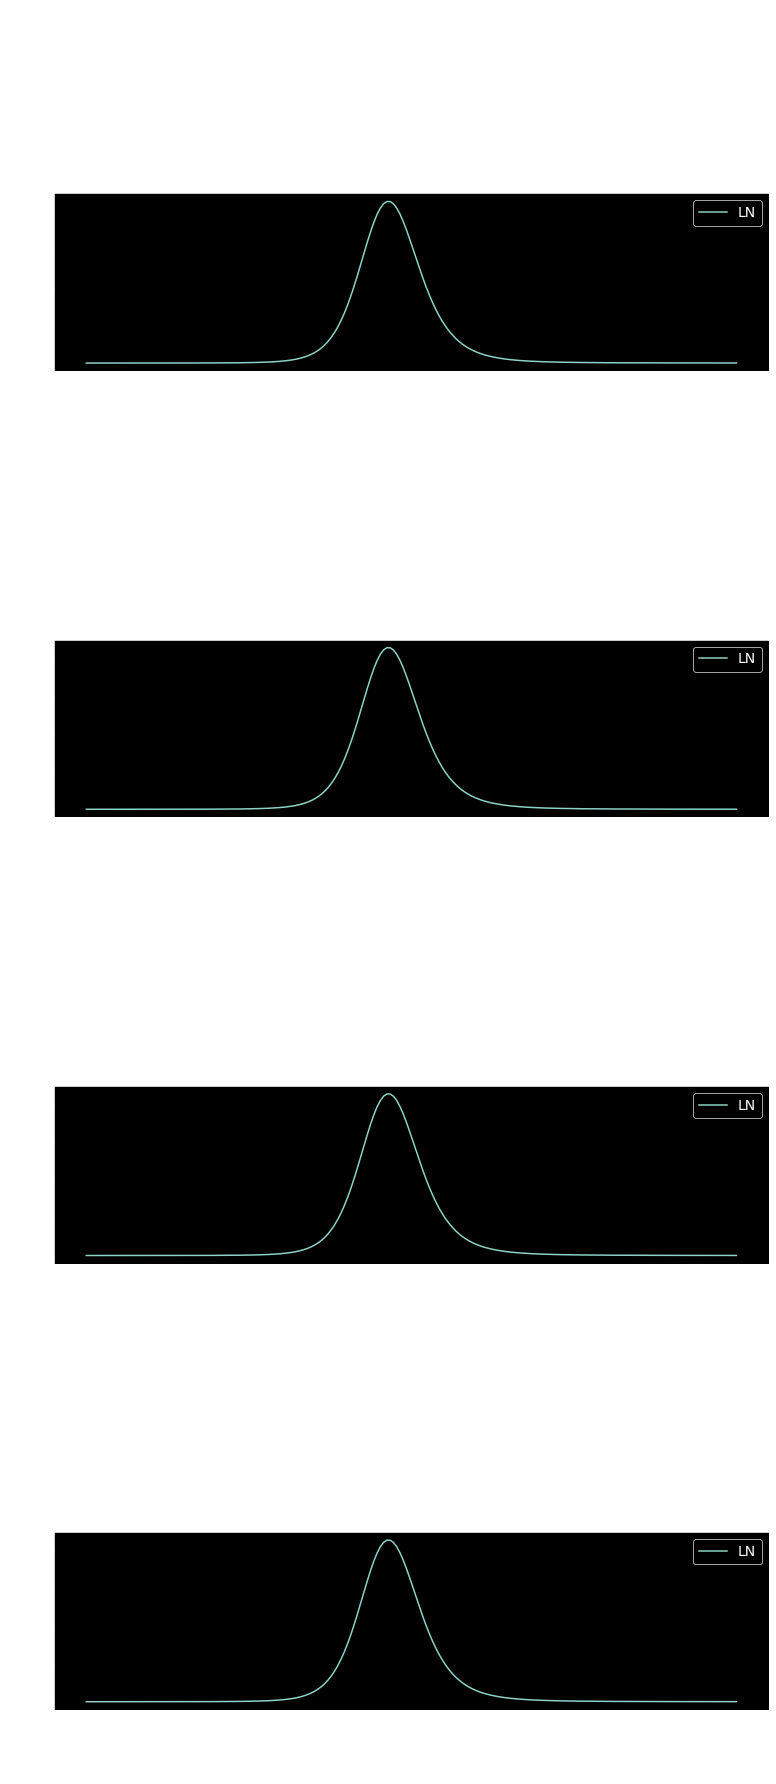

In [7]:
xlabel = 'strike\n\n'
ylabel = 'pdf'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    
    #x_grid = Model_LN.logmoneyness_grid
    x_grid = Model_LN.strike_grid
    
    pdf_LN = list(Model_LN.pdf_curve.values())
    ax.plot(x_grid, pdf_LN, label='LN')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

    ax.set_title(r'$f$={:.2%}'.format(Model_LN.f)+'\n' +\
                 r'a={:.2f}'.format(Model_LN.a)+'\n' +\
                 r'b={:.2f}'.format(Model_LN.b)+'\n' +\
                 r'rho={:.2f}'.format(Model_LN.rho)+'\n' +\
                 r'm={:.2f}'.format(Model_LN.m)+'\n' +\
                 r'sigma={:.2f}'.format(Model_LN.sigma)+'\n' +\
                 r'ATM(LN)={:.2%}'.format(Model_LN.ATM)+'\n'+\
                 r'expiry={}y'.format(T_expiry)+'\n',\
                )

plt.tight_layout()
plt.show()

## Backbone i.e ATM vol move implied by forward move

Sticky delta, parameters do not control the shape of the backbone : SVI really is a slice-by-slice parametrization and does not describe the smile dynamics.

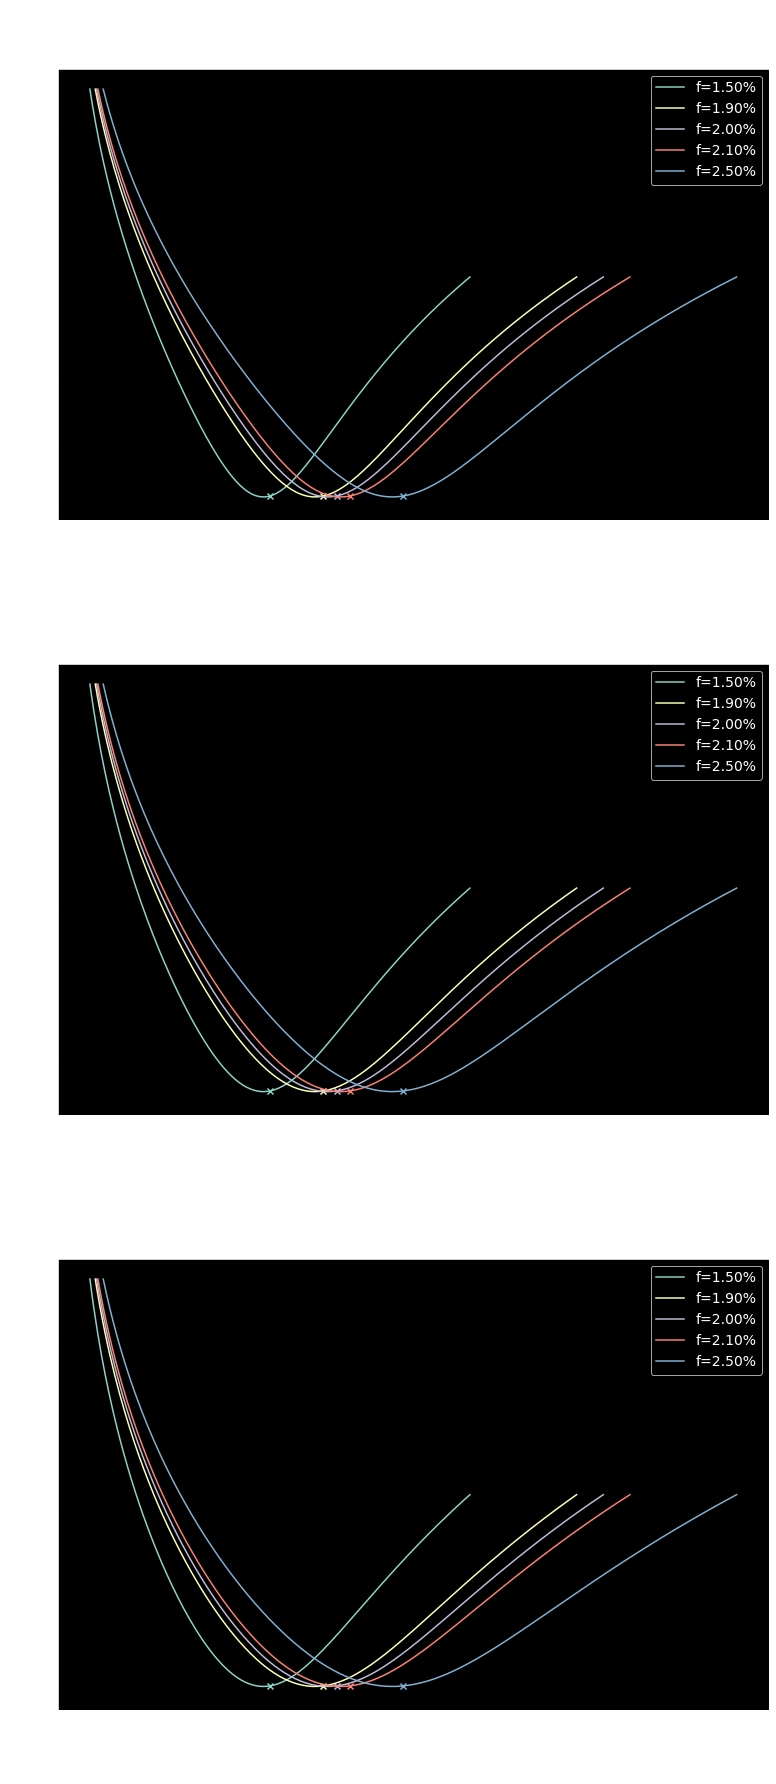

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1)

xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT

a_0=-0.0410
b_0=0.1331
m_0=0.1
rho_0=0.3060
sigma_0=0.415

a_shocks = [
    0.0,
    0.02,
    0.05,
]

f_shocks = [
    -50*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    50*ONE_BP
]

Model_LN = SVI_Raw_LN(
    a=a_0,
    b=b_0,
    rho=rho_0,
    m=m_0,
    sigma=sigma_0,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)
    
for i, ax in enumerate(axes):
    a = a_0 + a_shocks[i]
    Model_LN.a= a
#     b = b_0 + b_shocks[i]
#     Model_LN.b = b
#     m = m_0 + m_shocks[i]
#     Model_LN.m = m
#     rho = rho_0 + rho_shocks[i]
#     Model_LN.rho = rho
    
    for f_shock in f_shocks:
        Model_LN.f = f+f_shock
        smile = list(Model_LN.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(Model_LN.strike_grid, smile, label=label)
        ax.scatter([Model_LN.f], [Model_LN.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
        ax.set_title('{}\n'.format(Model_LN.vol_type)
                     +r'a={:.2f}'.format(Model_LN.a)+'\n'
                    )

plt.tight_layout()
plt.show()

## Parameter sensitivities
* $a$ and $b$ : both control the general level of the smile, a combination of both can help control the ATM and the wings simultaneously,
* $m$ : slides the smile along the strike axis,
* $\rho$ : controls the skew i.e rotates the smile,
* $\sigma$ : controls the convexity of the smile around ATM.

The main issue with the raw SVI is that each parameter has multiple effect (e.g $a$, $b$ and $\sigma$ all affecting the ATM). A better parametrization would be a combination of those in order to better separate the key driver of smile deformations.

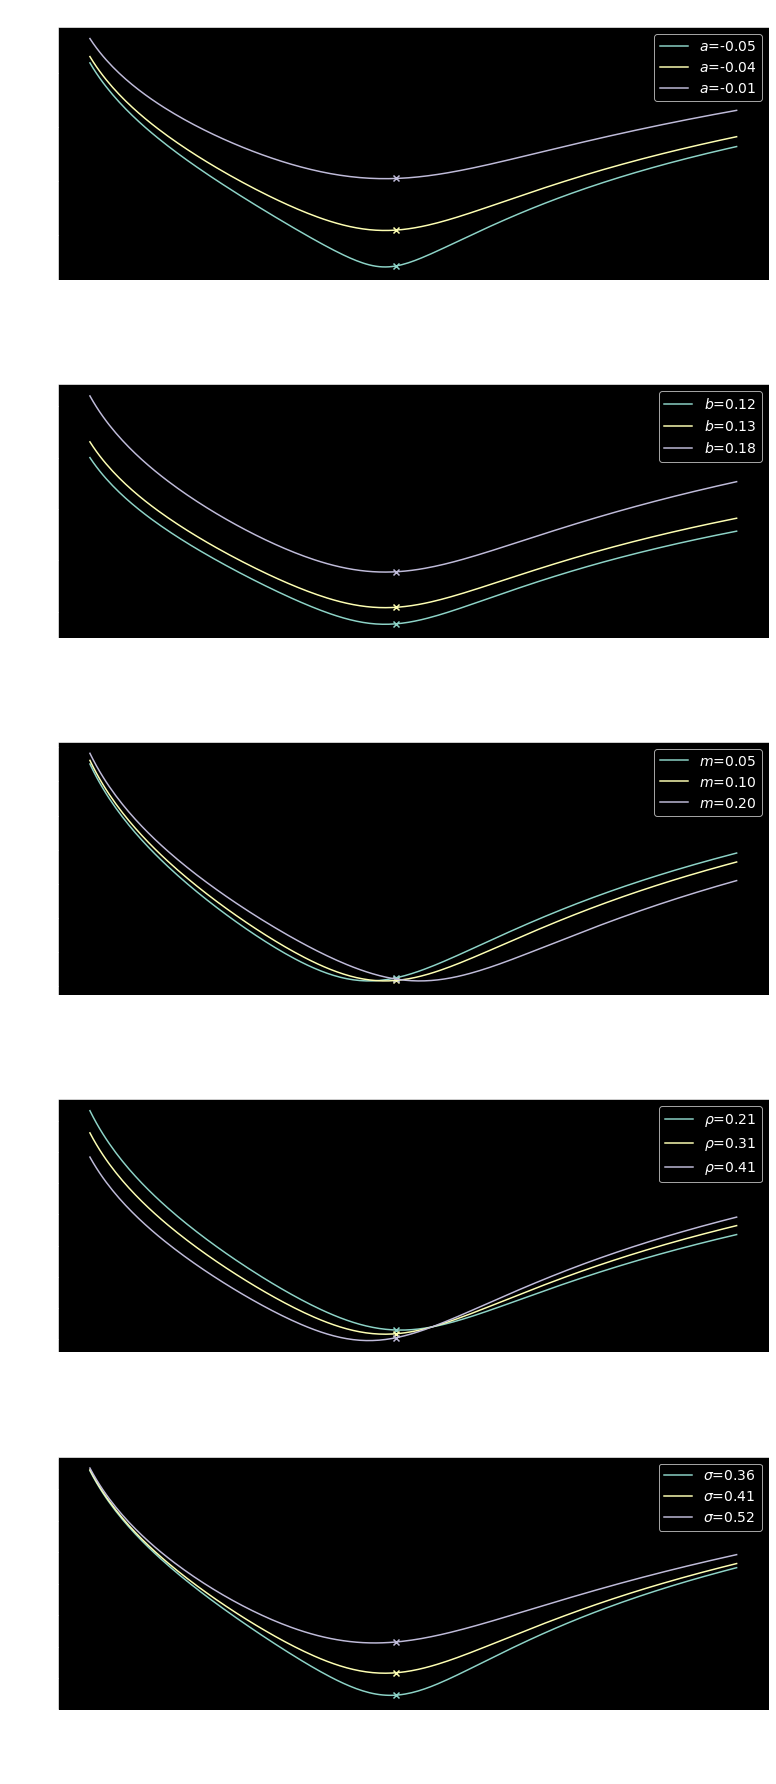

In [9]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT

a_0=-0.0410
b_0=0.1331
m_0=0.1
rho_0=0.3060
sigma_0=0.415

a_shocks = [-0.01, 0, 0.03]
b_shocks = [-0.015, 0, 0.05]
m_shocks = [-0.05, 0, 0.1]
rho_shocks = [-0.1, 0, 0.1]
sigma_shocks = [-0.05, 0, 0.1]

fig, axes = plt.subplots(nrows=5, ncols=1)

ax = axes[0]  
model = SVI_Raw_LN(
    a=a_0,
    b=b_0,
    rho=rho_0,
    m=m_0,
    sigma=sigma_0,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)

for a_shock in a_shocks:
    model.a = a_0+a_shock
    
    smile = list(model.smile.values())
    label = r'$a$={:.2f}'.format(model.a)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'$a$ shock')

ax = axes[1]  
model = SVI_Raw_LN(
    a=a_0,
    b=b_0,
    rho=rho_0,
    m=m_0,
    sigma=sigma_0,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)

for b_shock in b_shocks:
    model.b = b_0+b_shock
    
    smile = list(model.smile.values())
    label = r'$b$={:.2f}'.format(model.b)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'$b$ shock')
    
ax = axes[2]  
model = SVI_Raw_LN(
    a=a_0,
    b=b_0,
    rho=rho_0,
    m=m_0,
    sigma=sigma_0,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)

for m_shock in m_shocks:
    model.m = m_0+m_shock
    
    smile = list(model.smile.values())
    label = r'$m$={:.2f}'.format(model.m)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'$m$ shock')
    
ax = axes[3]  
model = SVI_Raw_LN(
    a=a_0,
    b=b_0,
    rho=rho_0,
    m=m_0,
    sigma=sigma_0,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)

for rho_shock in rho_shocks:
    model.rho = rho_0+rho_shock
    
    smile = list(model.smile.values())
    label = r'$\rho$={:.2f}'.format(model.rho)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'$\rho$ shock')
    
ax = axes[4]  
model = SVI_Raw_LN(
    a=a_0,
    b=b_0,
    rho=rho_0,
    m=m_0,
    sigma=sigma_0,
    f=f,
    n_strikes=N_STRIKES,
    moneyness_lo=moneyness_lo, 
    moneyness_hi=moneyness_hi
)

for sigma_shock in sigma_shocks:
    model.sigma = sigma_0+sigma_shock
    
    smile = list(model.smile.values())
    label = r'$\sigma$={:.2f}'.format(model.sigma)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    ax.set_title(r'$\sigma$ shock')    
    
plt.tight_layout()
plt.show()